In [96]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from shrimpgrad import Tensor, nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


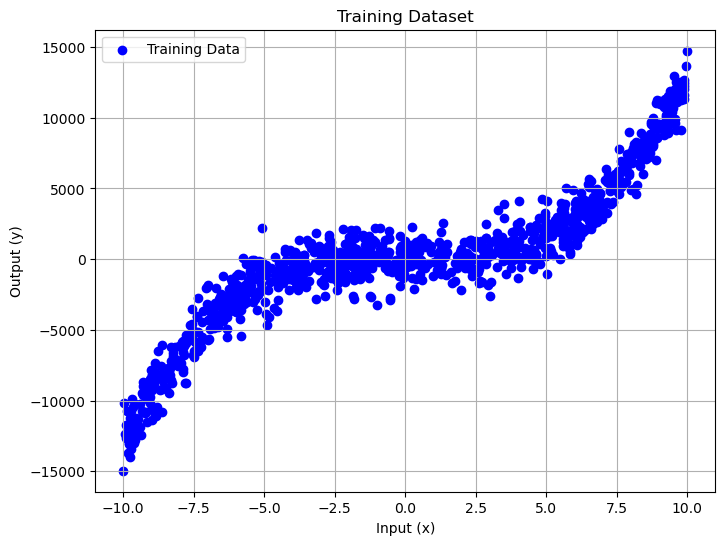

In [122]:
# Define the range of input values
num_samples = 1000
x_min = -10
x_max = 10

# Generate random input values within the specified range
x_train = np.random.uniform(x_min, x_max, num_samples)

# Calculate the corresponding output values based on the polynomial equation
y_train = x_train**3 + 12 * x_train**3 + 32

# Add some noise to the output values (optional)
noise_level = 1050
y_train += np.random.normal(0, noise_level, num_samples)

# Plot the training dataset
plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, color='blue', label='Training Data')
plt.title('Training Dataset')
plt.xlabel('Input (x)')
plt.ylabel('Output (y)')
plt.legend()
plt.grid(True)
plt.show()

In [123]:
x_train_raw = x_train.data.tolist()
y_train_raw = y_train.data.tolist()

In [124]:
y_train_raw[0:10]

[-2261.8411376940726,
 1644.1981034384955,
 -9247.594673004602,
 361.39818085851766,
 -4636.733989804956,
 12556.99553015306,
 161.3675545666137,
 -3317.5217555708714,
 -1241.5261863967166,
 -295.48665682859496]

In [128]:
x_train = Tensor.fromlist((1000,1), x_train_raw)
y_train = Tensor.fromlist((1000,1), y_train_raw)



In [137]:
x = np.random.uniform(low=-1.5, high=1.5, size=()).astype(np.float32)
x.flatten().tolist()

[0.45794254541397095]